
The feature selection notebook does a filter followed by a wrapper. It's capable of doing the filter on more than one file. The variable files are called vars1.csv, vars2.csv ...

The filter runs separately on each vars file and keeps the top num_filter variables from each file. If there are more than one vars files we'll again select the top num_filter variables across all the vars.csv files.

If balance = 0 the entire files are used. If balance != 0 then balance is the ratio of goods to bads retained for the rest of the feature selection. We keep all the rare class (bads) and downsample the goods. 

In [1]:
# load libraries
# %pip install mlxtend
# %pip install lightgbm

import pandas as pd
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
import datetime as dt
import gc
from sklearn.ensemble import RandomForestClassifier
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from lightgbm import LGBMClassifier
%matplotlib inline
start_time = dt.datetime.now()

In [2]:
# set some parameters
num_files = 1
num_filter = 80
num_wrapper = 20
balance = 0
detect_rate = .03
index_name = 'Recnum'
y_name = 'Fraud'
# index_name = 'record'
# y_name = 'fraud_label'
good_label = 0
bad_label = 1

## Run a filter on all the files

In [3]:
%%time
filter_score_df_list = []
for i in range(num_files):
#     file_name = "vars"+str(i+1)+'.csv'
    file_name = 'Create_vars.csv' # 後來把file name 改為create_vars
    df = pd.read_csv(file_name)
    print("********** working on",file_name,"size is",df.shape)
    df = df.set_index(index_name) 
    df = df[df.index <= 84300] # remove the last two months as the out-of-time data (OOT)
    df = df[df.index >= 2995] # remove the first 2 weeks of records since their variables aren't well formed
    df['RANDOM'] = np.random.ranf(len(df)) # add a random number variable to make sure it doesn't come up as important
    goods = df[df[y_name] == good_label]
    bads = df[df[y_name] == bad_label]
    del df # don't need this file anymore
    num_goods = len(goods)
    num_bads = len(bads)
    num_vars = len(bads.columns)-2
    if(balance != 0):
        if(i == 0):
            num_goods_desired = int(min(num_goods,num_bads*balance))
            goods = goods.sample(n=num_goods_desired,random_state=1)
            goods_keep = list(goods.index)
            goods_keep.sort()
    
        if(i > 0):
            goods = goods.loc[goods_keep] 
            
    df_sampled = pd.concat([goods,bads])
    df_sampled.sort_index(inplace=True)
    filter_score = pd.DataFrame(np.zeros((num_vars+1,2)))
    filter_score.columns = ['variable','score']   
    j = 0
    for column in df_sampled:
        filter_score.loc[j,'variable'] = column
        filter_score.loc[j,'score'] = sps.ks_2samp(goods[column],bads[column])[0]
        j = j+1
        if j%100 == 0:
            print(j)

    filter_score.sort_values(by=['score'], ascending=False, inplace=True)
    vars_keep = list(filter_score['variable'][1:num_filter+1]) 
    print(file_name,filter_score.head(20))
    if(i == 0): # if first time through need to initialize some stuff
        Y = pd.DataFrame(df_sampled[y_name], index=df_sampled.index)
        df_top = df_sampled.filter(vars_keep, axis=1)
            
    if(i > 0): # if more than one variable file we use this loop
        data_new_top = df_sampled.filter(vars_keep, axis=1)
        df_top = pd.concat([df_top,data_new_top], axis=1)
    
    """
    Not that it matters a lot but I usually put the dataframes in a list and concatenate them after coming out of loop.
    Someone at my previous organization said that it was more efficient but I did not check the efficiency benefit myself.
    """
#     filter_score = pd.concat([filter_score,new])
    filter_score_df_list.append(filter_score)
    
    del goods # delete these before starting the next file, if any
    del bads
    gc.collect()
filter_score = pd.concat(filter_score_df_list)

********** working on Create_vars.csv size is (96397, 1187)
100
200
300
400
500
600
700
800
900
1000
1100
Create_vars.csv                 variable     score
9                  Fraud  1.000000
881     card_zip_total_7  0.684517
331   card_merch_total_7  0.681080
872     card_zip_total_3  0.677563
322   card_merch_total_3  0.675092
340  card_merch_total_14  0.674967
377   card_state_total_3  0.674228
890    card_zip_total_14  0.671828
386   card_state_total_7  0.669686
395  card_state_total_14  0.669055
863     card_zip_total_1  0.660539
368   card_state_total_1  0.659137
349  card_merch_total_30  0.658364
313   card_merch_total_1  0.658215
888      card_zip_max_14  0.657780
879       card_zip_max_7  0.657460
899    card_zip_total_30  0.656306
338    card_merch_max_14  0.654192
897      card_zip_max_30  0.650861
329     card_merch_max_7  0.650624
CPU times: user 42.6 s, sys: 8.96 s, total: 51.5 s
Wall time: 1min 5s


In [4]:
filter_score.sort_values(by=['score'], ascending=False, inplace=True)

In [7]:
filter_score.head(30)

,variable,score
9,Fraud,1.000000
881,card_zip_total_7,0.684517
331,card_merch_total_7,0.681080
872,card_zip_total_3,0.677563
322,card_merch_total_3,0.675092
340,card_merch_total_14,0.674967
377,card_state_total_3,0.674228
890,card_zip_total_14,0.671828
386,card_state_total_7,0.669686
395,card_state_total_14,0.669055


In [8]:
filter_score.to_csv('Filter_score.csv')

In [6]:
filter_score.tail(10)

,variable,score
1170,Amount_date_count_1_by_30,0.0
664,Amount_transtype_actual/med_7,0.0
636,Amount_transtype_actual/max_0,0.0
637,Amount_transtype_actual/med_0,0.0
645,Amount_transtype_actual/max_1,0.0
646,Amount_transtype_actual/med_1,0.0
654,Amount_transtype_actual/max_3,0.0
655,Amount_transtype_actual/med_3,0.0
663,Amount_transtype_actual/max_7,0.0
967,Amount_state_actual/med_0,0.0


In [7]:
filter_score.shape

(1187, 2)

In [8]:
filter_score.sort_values(by=['score'], ascending=False, inplace=True)
vars_keep = list(filter_score['variable'][num_files:num_filter+3])
print(i,' vars_keep:',vars_keep)

0  vars_keep: ['card_zip_total_7', 'card_merch_total_7', 'card_zip_total_3', 'card_merch_total_3', 'card_merch_total_14', 'card_state_total_3', 'card_zip_total_14', 'card_state_total_7', 'card_state_total_14', 'card_zip_total_1', 'card_state_total_1', 'card_merch_total_30', 'card_merch_total_1', 'card_zip_max_14', 'card_zip_max_7', 'card_zip_total_30', 'card_merch_max_14', 'card_zip_max_30', 'card_merch_max_7', 'card_zip_max_3', 'card_merch_max_30', 'card_state_max_3', 'card_state_max_7', 'card_merch_max_3', 'card_state_total_30', 'card_state_max_14', 'card_zip_max_1', 'card_state_max_1', 'Merch description_total_3', 'card_merch_max_1', 'Merch description_total_1', 'card_merch_total_0', 'card_state_total_0', 'Merchnum_state_total_3', 'card_zip_total_0', 'Merch description_max_0', 'Merch_address_total_3', 'Merchnum_state_max_0', 'Merch_address_total_1', 'Merchnum_state_total_1', 'card_zip_max_0', 'card_state_max_0', 'Merchnum_zip_total_3', 'card_transtype_total_3', 'Cardnum_total_3', 'c

In [9]:
vars_keep_df = pd.DataFrame({'col':vars_keep})
vars_keep_df.to_csv('vars_keep_filter.csv',index=False)
df_keep = df_top.filter(vars_keep, axis=1)
df_keep.head()

,card_zip_total_7,card_merch_total_7,card_zip_total_3,card_merch_total_3,card_merch_total_14,card_state_total_3,card_zip_total_14,card_state_total_7,card_state_total_14,card_zip_total_1,...,Date_zip_max_3,Date_zip_max_0,Date_zip_max_30,Merch zip_max_0,Date_zip_max_1,Date_zip_max_7,Merchnum_zip_max_1,card_state_avg_7,Merchnum_total_1,card_transtype_max_0
Recnum,,,,,,,,,,,,,,,,,,,,,
2995,1023.04,1023.04,174.20,174.20,1023.04,174.20,1023.04,1023.04,1023.04,174.20,...,174.20,174.20,174.20,174.20,174.20,174.20,174.20,341.013333,174.20,174.20
2996,250.00,250.00,250.00,250.00,250.00,250.00,250.00,250.00,250.00,250.00,...,250.00,250.00,250.00,250.00,250.00,250.00,250.00,250.000000,250.00,250.00
2997,76.85,76.85,76.85,76.85,76.85,76.85,76.85,76.85,76.85,53.88,...,53.88,53.88,53.88,53.88,53.88,53.88,999.90,38.425000,1116.55,53.88
2998,1269.00,1269.00,1269.00,1269.00,1269.00,1269.00,1269.00,1269.00,1269.00,1269.00,...,1269.00,1269.00,1269.00,1269.00,1269.00,1269.00,1269.00,1269.000000,1481.35,1269.00
2999,288.38,288.38,288.38,288.38,288.38,288.38,288.38,288.38,288.38,288.38,...,288.38,288.38,288.38,288.38,288.38,288.38,601.52,288.380000,1189.68,288.38


In [10]:
df_keep.shape

(80983, 80)

In [11]:
Y.head()

,Fraud
Recnum,
2995,0
2996,0
2997,0
2998,0
2999,0


In [12]:
Y = Y.values
Y_save = Y.copy()

In [13]:
# Y = np.array(Y)
X = df_keep
print(Y)

[[0]
 [0]
 [0]
 ...
 [0]
 [0]
 [0]]


In [14]:
print('time to here:', dt.datetime.now() - start_time)

time to here: 0:04:30.587728


In [15]:
print(X.shape,Y.shape)

(80983, 80) (80983, 1)


In [16]:
print(type(X),type(Y))

<class 'pandas.core.frame.DataFrame'> <class 'numpy.ndarray'>


In [17]:
# I'd like to define a scoring for the wrapper that's KS, but I haven't gotten around to this yet.
# def KSscore(classifier, x,y)
#     goods = 

In [17]:
def fdr(classifier, x, y, cutoff=detect_rate):
# Calculates FDR score for the given classifier on dataset x and y with cutoff value
# get the probability list from the given classifier
    return fdr_prob(y, classifier.predict_proba(x), cutoff)
def fdr_prob(y, y_prob, cutoff=detect_rate):
    if len(y_prob.shape) != 1:    # sometimes the proba list can contain many columns, one for each category
        y_prob = y_prob[:, -1:]   # only the last one (fraud_label==1) is used here.
    num_fraud = len(y[y == 1])    # count the total nunber of frauds   
# sort the proba list from high to low while retain the true (not predicted) fraud label
    sorted_prob = np.asarray(sorted(zip(y_prob, y), key=lambda x: x[0], reverse=True))
    cutoff_bin = sorted_prob[0:int(len(y) * cutoff), 1:]  # 3% cutoff
# return the FDR score (#fraud_in_cutoff / #total_fraud)
    return len(cutoff_bin[cutoff_bin == 1]) / num_fraud   

In [18]:
%%time
import warnings 
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 
# If you're doing forward selection it's enough to stop at num_wrapper variables. 
# If you're doing backward selection you need to go through all the variables to get 
# a sorted list of num_wrapper variables.
nfeatures = len(X.columns)
# clf = RandomForestClassifier(n_estimators=5) # simple, fast nonlinear model for the wrapper
clf = LGBMClassifier(n_estimators=30,num_leaves=3) # simple, fast nonlinear model for the wrapper
sfs = SFS(clf,k_features=num_wrapper,forward=True,verbose=2,scoring=fdr,cv=10,n_jobs=-1) # forward selection
# sfs = SFS(clf,k_features=1,forward=False,verbose=2,scoring=fdr,cv=2,n_jobs=-1) # backward selection
sfs.fit(X,Y)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   48.5s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  1.6min finished

[2022-04-11 12:44:29] Features: 1/20 -- score: 0.6151697407110398[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   40.3s
[Parallel(n_jobs=-1)]: Done  79 out of  79 | elapsed:  1.6min finished

[2022-04-11 12:46:02] Features: 2/20 -- score: 0.658019246190858[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   43.8s
[Parallel(n_jobs=-1)]: Done  78 out of  78 | elapsed:  1.6min finished

[2022-04-11 12:47:41] Features: 3/20 -- score: 0.6833600641539695[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   47.6s
[Parallel(n_jobs=-1)]: Done  77 out of

CPU times: user 9.87 s, sys: 7.25 s, total: 17.1 s
Wall time: 46min 56s


[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:  3.2min finished

[2022-04-11 13:29:51] Features: 20/20 -- score: 0.696003742314889

SequentialFeatureSelector(cv=10,
                          estimator=LGBMClassifier(n_estimators=30,
                                                   num_leaves=3),
                          k_features=20, n_jobs=-1,
                          scoring=<function fdr at 0x7fc1a156edc0>, verbose=2)

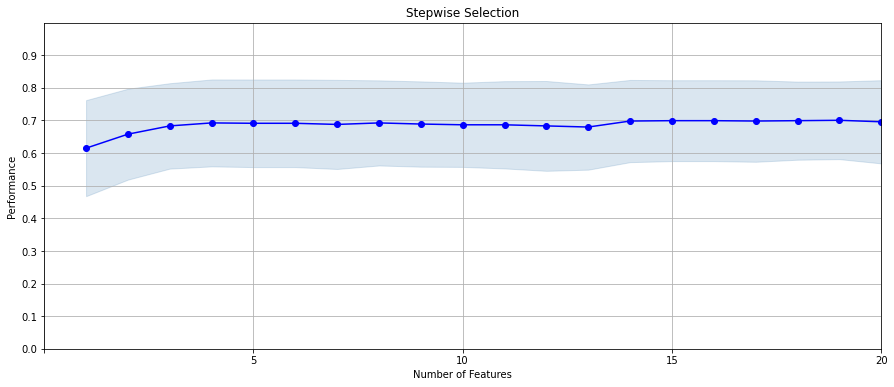

In [19]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
fig1 = plot_sfs(sfs.get_metric_dict(),kind='std_dev', figsize=(15, 6))
plt.xticks(np.arange(0, len(X.columns), step=5))
plt.yticks(np.arange(0,1,step=.1))
plt.ylim([0., 1])
plt.xlim(0,num_wrapper)
plt.title('Stepwise Selection')
plt.grid()
plt.savefig('FS_fdr.png')
plt.show()

In [20]:
vars_FS = pd.DataFrame.from_dict(sfs.get_metric_dict()).T

In [21]:
ordered_vars_FS = vars_FS.copy()
for i in range(len(ordered_vars_FS)):
    ordered_vars_FS.loc[i+1,'add variables in this order'] = int(i+1)
    if i+1 == 1:
        ordered_vars_FS.loc[i+1,'variable name'] = list(ordered_vars_FS.loc[i+1,'feature_names'])[0]
    else:
        ordered_vars_FS.loc[i+1,'variable name'] = set(ordered_vars_FS.loc[i+1,'feature_names']) - set(ordered_vars_FS.loc[i,'feature_names'])

In [22]:
ordered_vars_FS

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err,add variables in this order,variable name
1,"(2,)","[0.4482758620689655, 0.5632183908045977, 0.827...",0.61517,"(card_zip_total_3,)",0.109339,0.147216,0.049072,1.0,card_zip_total_3
2,"(2, 53)","[0.4942528735632184, 0.6206896551724138, 0.724...",0.658019,"(card_zip_total_3, card_state_max_30)",0.10348,0.139328,0.046443,2.0,card_state_max_30
3,"(2, 4, 53)","[0.5747126436781609, 0.6091954022988506, 0.804...",0.68336,"(card_zip_total_3, card_merch_total_14, card_s...",0.097236,0.13092,0.04364,3.0,card_merch_total_14
4,"(2, 4, 31, 53)","[0.5747126436781609, 0.6091954022988506, 0.804...",0.692555,"(card_zip_total_3, card_merch_total_14, card_m...",0.098958,0.133239,0.044413,4.0,card_merch_total_0
5,"(2, 4, 31, 32, 53)","[0.5632183908045977, 0.6091954022988506, 0.804...",0.691406,"(card_zip_total_3, card_merch_total_14, card_m...",0.099743,0.134296,0.044765,5.0,card_state_total_0
6,"(2, 4, 31, 32, 34, 53)","[0.5632183908045977, 0.6091954022988506, 0.804...",0.691406,"(card_zip_total_3, card_merch_total_14, card_m...",0.099743,0.134296,0.044765,6.0,card_zip_total_0
7,"(2, 4, 17, 31, 32, 34, 53)","[0.5747126436781609, 0.6091954022988506, 0.804...",0.687931,"(card_zip_total_3, card_merch_total_14, card_z...",0.101443,0.136585,0.045528,7.0,card_zip_max_30
8,"(2, 4, 17, 24, 31, 32, 34, 53)","[0.5747126436781609, 0.6091954022988506, 0.781...",0.692555,"(card_zip_total_3, card_merch_total_14, card_z...",0.096895,0.130461,0.043487,8.0,card_state_total_30
9,"(2, 4, 17, 24, 31, 32, 34, 53, 77)","[0.5632183908045977, 0.6091954022988506, 0.804...",0.689107,"(card_zip_total_3, card_merch_total_14, card_z...",0.097106,0.130745,0.043582,9.0,card_state_avg_7
10,"(2, 4, 17, 24, 31, 32, 34, 53, 61, 77)","[0.5632183908045977, 0.6091954022988506, 0.793...",0.686808,"(card_zip_total_3, card_merch_total_14, card_z...",0.095875,0.129088,0.043029,10.0,card_zip_avg_3


In [23]:
ordered_vars_FS.to_csv('VarsFS.csv', index=False)

In [24]:
ordered_vars_FS['variable name']

1        card_zip_total_3
2       card_state_max_30
3     card_merch_total_14
4      card_merch_total_0
5      card_state_total_0
6        card_zip_total_0
7         card_zip_max_30
8     card_state_total_30
9        card_state_avg_7
10         card_zip_avg_3
11    card_merch_total_30
12     card_state_total_7
13        card_zip_avg_14
14        card_zip_max_14
15       card_merch_avg_7
16       card_merch_avg_3
17      card_merch_avg_14
18      card_merch_max_30
19         card_zip_avg_7
20       card_state_max_0
Name: variable name, dtype: object

In [25]:
vars_keep = ordered_vars_FS['variable name']
vars_keep_list = ordered_vars_FS['variable name'].tolist()
vars_keep.to_csv('final_vars_list.csv',index=False)

In [26]:
vars_keep

1        card_zip_total_3
2       card_state_max_30
3     card_merch_total_14
4      card_merch_total_0
5      card_state_total_0
6        card_zip_total_0
7         card_zip_max_30
8     card_state_total_30
9        card_state_avg_7
10         card_zip_avg_3
11    card_merch_total_30
12     card_state_total_7
13        card_zip_avg_14
14        card_zip_max_14
15       card_merch_avg_7
16       card_merch_avg_3
17      card_merch_avg_14
18      card_merch_max_30
19         card_zip_avg_7
20       card_state_max_0
Name: variable name, dtype: object

In [27]:
vars_keep_list.append(index_name)
vars_keep_list.append(y_name)
vars_keep_list

['card_zip_total_3',
 'card_state_max_30',
 'card_merch_total_14',
 'card_merch_total_0',
 'card_state_total_0',
 'card_zip_total_0',
 'card_zip_max_30',
 'card_state_total_30',
 'card_state_avg_7',
 'card_zip_avg_3',
 'card_merch_total_30',
 'card_state_total_7',
 'card_zip_avg_14',
 'card_zip_max_14',
 'card_merch_avg_7',
 'card_merch_avg_3',
 'card_merch_avg_14',
 'card_merch_max_30',
 'card_zip_avg_7',
 'card_state_max_0',
 'Recnum',
 'Fraud']

In [28]:
df = pd.read_csv(file_name)

In [29]:
df_keep = df.filter(vars_keep_list, axis=1)
print(df_keep.shape)

(96397, 22)


In [30]:
df_keep.to_csv('vars_final.csv',index=False)

In [31]:
print('time to here:', dt.datetime.now() - start_time)

time to here: 0:53:23.068600


## KS with the top 20 variables

In [1]:
import pandas as pd

In [3]:
df_1= pd.read_csv('Filter_score.csv', index_col=0)
df_1

,variable,score
9,Fraud,1.000000
881,card_zip_total_7,0.684517
331,card_merch_total_7,0.681080
872,card_zip_total_3,0.677563
322,card_merch_total_3,0.675092
...,...,...
646,Amount_transtype_actual/med_1,0.000000
654,Amount_transtype_actual/max_3,0.000000
655,Amount_transtype_actual/med_3,0.000000
663,Amount_transtype_actual/max_7,0.000000


In [7]:
df_2= pd.read_csv('final_vars_list.csv')
df_2['variable']= df_2['variable name']
df_2

,variable name,variable
0,card_zip_total_3,card_zip_total_3
1,card_state_max_30,card_state_max_30
2,card_merch_total_14,card_merch_total_14
3,card_merch_total_0,card_merch_total_0
4,card_state_total_0,card_state_total_0
5,card_zip_total_0,card_zip_total_0
6,card_zip_max_30,card_zip_max_30
7,card_state_total_30,card_state_total_30
8,card_state_avg_7,card_state_avg_7
9,card_zip_avg_3,card_zip_avg_3


In [9]:
pd.merge(df_2,df_1, on='variable')

,variable name,variable,score
0,card_zip_total_3,card_zip_total_3,0.677563
1,card_state_max_30,card_state_max_30,0.598203
2,card_merch_total_14,card_merch_total_14,0.674967
3,card_merch_total_0,card_merch_total_0,0.611202
4,card_state_total_0,card_state_total_0,0.610645
5,card_zip_total_0,card_zip_total_0,0.609916
6,card_zip_max_30,card_zip_max_30,0.650861
7,card_state_total_30,card_state_total_30,0.635598
8,card_state_avg_7,card_state_avg_7,0.587104
9,card_zip_avg_3,card_zip_avg_3,0.590436


In [ ]:
df['Merchnum'].map(merchnum_zip)